# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [1]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("done loading")

done loading


In [2]:
### To start off let's do a basic data summary.

# number of training examples
n_train = len(X_train)

# number of testing examples
n_test = len(X_test)

# what's the shape of an image?
image_shape = X_train[0].shape

# how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


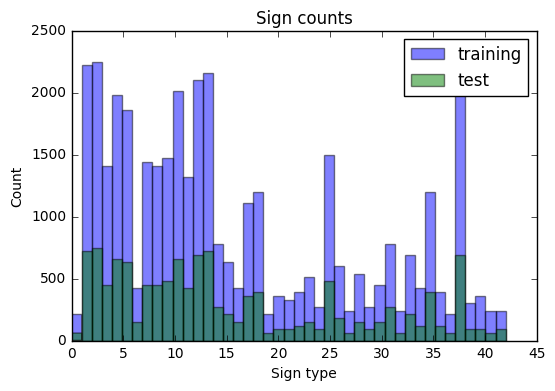

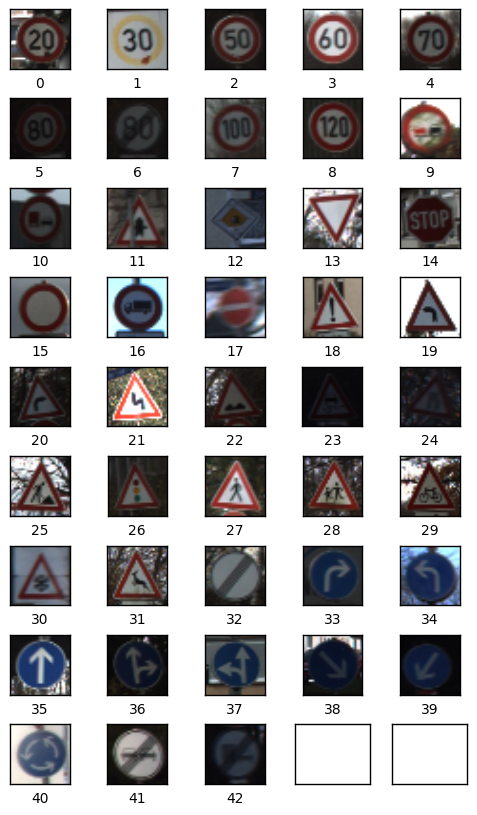

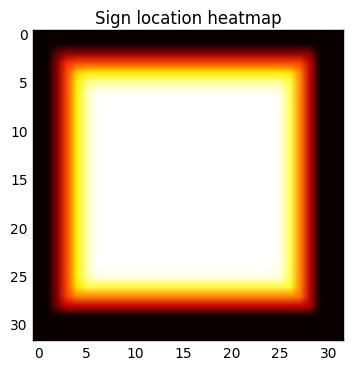

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np

#Histogram of sign types
plt.figure()
n, bins, patches = plt.hist(y_train, bins=43, alpha=0.5, label="training")
n, bins, patches = plt.hist(y_test, bins=43, alpha=0.5, label="test")
plt.title("Sign counts")
plt.xlabel("Sign type")
plt.ylabel("Count")
plt.legend(loc='upper right')
plt.show()

#Show example of each sign type
images_by_type = dict(zip(y_train, X_train))
fig, axes = plt.subplots(9, 5)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
fig.set_figheight(10)

for i, ax in enumerate(axes.flat):
    if i < n_classes:
        example_image = images_by_type[i]
        # Plot image.
        ax.imshow(example_image)

        xlabel = str(i)

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)

    # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])

# Ensure the plot is shown correctly with multiple plots
# in a single Notebook cell.
plt.show()


#heatmap of sign locations in image
plt.figure()
heatmap = np.zeros([image_shape[0], image_shape[1]], dtype=int)
for size,coords in zip(train['sizes'], train['coords']):
    scale_matrix = np.mat([[32./float(size[0]), 0.],
                          [0., 32./float(size[1])]])
    coords = coords.reshape([2,2])
    normalized_coords = np.dot(coords, scale_matrix)
    for x in range(int(normalized_coords[0,0]), int(normalized_coords[1,0])):
        for y in range(int(normalized_coords[0,1]), int(normalized_coords[1,1])):
            heatmap[x,y] += 1
        
plt.imshow(heatmap, cmap='hot')
plt.title("Sign location heatmap")
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.

# for one-hot encoding
from tensorflow.contrib.learn.python.learn.datasets import mnist

def normalize_image(image):
    max_pixel = np.amax(image)
    min_pixel = np.amin(image)
    return (image - min_pixel)/(max_pixel - min_pixel)

def to_flattened_rgb(image_list):
    return np.array([normalize_image((np.reshape(i, [1024, 3]))/255.) for i in image_list])

X_train = to_flattened_rgb(X_train)
y_train = mnist.dense_to_one_hot(y_train, n_classes)

X_test = to_flattened_rgb(X_test)
y_test = mnist.dense_to_one_hot(y_test, n_classes)

print ("done preprocessing")

done preprocessing


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
Preprocessing of features (images) consisted of:
* Flattening from row,column,rgb (32,32,3) to index,rgb(1024,3)
* Normalizing each image to (0...1) range

Labels were transformed from dense to one-hot encoding

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**

I set up the training data by shuffling the order of images before every epoch. I did not use a validation set. I used the test set as given.

I noticed that there was an unbalanced number of examples per-class in the training and test data, and considered generating additional images of the under-represented classes by jittering the images using affine transforms. In the end I ran out of time to do this, and relied on the fact that the class distribution is roughly equal in the test set and training set.

In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [7]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [8]:
#Create a convolutional layer
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=num_filters)
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)
    return layer, weights

In [9]:
# Reshape the layer to [batch_size, (width*height*num_channels)].
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat, num_features

In [10]:
#New fully-connected layer weights, biases, and optional ReLU
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [11]:
import tensorflow as tf

# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# We know that sign images are 32 pixels in each dimension.
img_size = 32

# Images pixels are stored in flattened tensors of this length
img_size_flat = img_size * img_size

# Tuple with (height, width, RGB) of images used to reshape arrays.
img_shape = (img_size, img_size, 3)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 3

# Reshape from (1024,3) to (32,32,3), so it can be an input to convolutional layer
x = tf.placeholder(tf.float32, shape=[None, img_size_flat, num_channels], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

# One-hot encoded labels layer
y_true = tf.placeholder(tf.float32, shape=[None, n_classes], name='y_true')
# Labels (derived by taking index of maximum one-hot encoding value )
y_true_cls = tf.argmax(y_true, dimension=1)

# dropout (keep probability)
keep_prob = tf.placeholder(tf.float32)  

#First convolutional layer
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

#Second convolutional layer
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)


#Flatten conv2 and feed to a fully connected layer with dropout
layer_flat, num_features = flatten_layer(layer_conv2)
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)
layer_fc1 = tf.nn.dropout(layer_fc1, keep_prob)

#Feed fully-connected layer to fully-connected classifier layer
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=n_classes,
                         use_relu=False)


#Cost fuction (plus some utility nodes to easily report accuracy)
y_pred = tf.nn.softmax(layer_fc2)
top_k = tf.nn.top_k(y_pred, 5)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

#Use AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My starting point for the network architecture was from this tutorial:
https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
I started with the network architecture from that example, and added a dropout to reduce overfitting.
The final architecture is:
```
RGB input (batch_size x 32x32x3)
--> 5x5 convolution, 16 channels -> 2x2 maxpooling --> ReLU  (batch_size x 16x16x16)
--> 5x5 convolution, 32 channels -> 2x2 maxpooling --> ReLU (batch_size x 8x8x32)
--> flatten --> fully connected layer --> ReLU --> dropout (batch_size x 128)
--> classifier --> prediction!
```

In [12]:
### Train your model here.
### Feel free to use as many code cells as needed.

def shuffle_training_set():
    global current_index, X_train, y_train
    current_index = 0
    perm = np.arange(n_train)
    np.random.shuffle(perm)
    X_train = X_train[perm]
    y_train = y_train[perm]
    

#Gets the next batch of images (randomize order at the beginning of each epoch)
def next_batch(batch_size):
    global current_index
    assert current_index + batch_size < n_train
    batch_x, batch_y = X_train[current_index:current_index + batch_size], y_train[current_index:current_index + batch_size]
    current_index += batch_size
    return batch_x, batch_y

In [13]:
import time
from datetime import timedelta


# Optimize one epoch
def optimize():
    # Start-time used for printing time-usage below.
    start_time = time.time()

    dropout = 0.55
    shuffle_training_set()

    train_batch_size = 256
    batch_num = 0
    while current_index + train_batch_size < n_train:
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch,
                           keep_prob: dropout}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 batches.
        if batch_num % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization batch: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(batch_num, acc))
        batch_num = batch_num + 1

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Epoch time usage: " + str(timedelta(seconds=int(round(time_dif)))))



In [14]:
def plot_images_with_labels(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [15]:
def plot_example_errors(cls_pred, cls_true, correct):
    # This function is called from print_test_accuracy() below.
    
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.
    
    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.
    
    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = X_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    
    # Get the true classes for those images
    cls_true = cls_true[incorrect]
    
 
    # Plot the first 9 images.
    plot_images_with_labels(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cls_pred, cls_true):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, range(n_classes))
    plt.yticks(tick_marks, range(n_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [16]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test_images = len(X_test)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test_images, dtype=np.int)

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test_images:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test_images)

        # Get the images from the test-set between index i and j.
        images = X_test[i:j, :]

        # Get the associated labels.
        labels = y_test[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels,
                     keep_prob: 1.}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = np.argmax(y_test[:len(cls_pred)], axis=1)

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test_images

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred, cls_true, correct=correct)
    
    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred, cls_true)

Epoch 0:
Optimization batch:      0, Training Accuracy:   2.3%
Optimization batch:    100, Training Accuracy:   8.6%
Epoch time usage: 0:01:33
Model saved in file: model.ckpt
Accuracy on Test-Set: 20.4% (2579 / 12630)
Example errors:


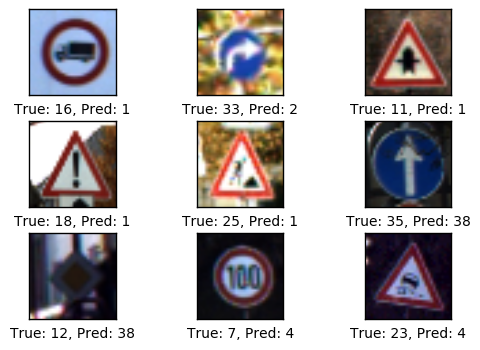

Confusion Matrix:


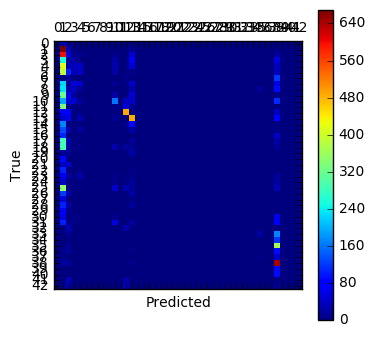

Epoch 1:
Optimization batch:      0, Training Accuracy:  16.4%
Optimization batch:    100, Training Accuracy:  28.1%
Epoch time usage: 0:01:32
Model saved in file: model.ckpt
Epoch 2:
Optimization batch:      0, Training Accuracy:  35.2%
Optimization batch:    100, Training Accuracy:  38.3%
Epoch time usage: 0:01:29
Model saved in file: model.ckpt
Epoch 3:
Optimization batch:      0, Training Accuracy:  39.5%
Optimization batch:    100, Training Accuracy:  50.8%
Epoch time usage: 0:01:28
Model saved in file: model.ckpt
Epoch 4:
Optimization batch:      0, Training Accuracy:  50.8%
Optimization batch:    100, Training Accuracy:  52.7%
Epoch time usage: 0:01:27
Model saved in file: model.ckpt
Epoch 5:
Optimization batch:      0, Training Accuracy:  60.5%
Optimization batch:    100, Training Accuracy:  67.6%
Epoch time usage: 0:01:27
Model saved in file: model.ckpt
Accuracy on Test-Set: 69.5% (8778 / 12630)
Example errors:


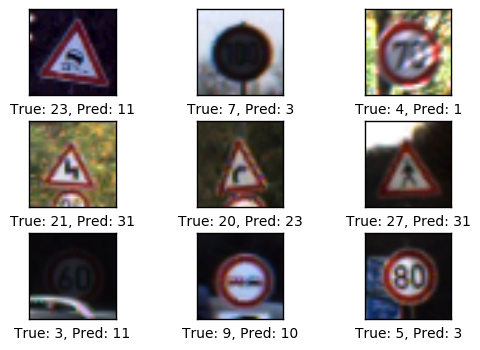

Confusion Matrix:


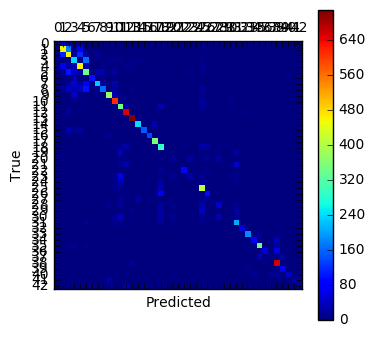

Epoch 6:
Optimization batch:      0, Training Accuracy:  63.3%
Optimization batch:    100, Training Accuracy:  64.5%
Epoch time usage: 0:01:27
Model saved in file: model.ckpt
Epoch 7:
Optimization batch:      0, Training Accuracy:  70.3%
Optimization batch:    100, Training Accuracy:  71.9%
Epoch time usage: 0:01:32
Model saved in file: model.ckpt
Epoch 8:
Optimization batch:      0, Training Accuracy:  71.5%
Optimization batch:    100, Training Accuracy:  76.2%
Epoch time usage: 0:01:27
Model saved in file: model.ckpt
Epoch 9:
Optimization batch:      0, Training Accuracy:  69.9%
Optimization batch:    100, Training Accuracy:  76.2%
Epoch time usage: 0:01:27
Model saved in file: model.ckpt
Epoch 10:
Optimization batch:      0, Training Accuracy:  81.2%
Optimization batch:    100, Training Accuracy:  82.0%
Epoch time usage: 0:01:27
Model saved in file: model.ckpt
Accuracy on Test-Set: 80.4% (10157 / 12630)
Example errors:


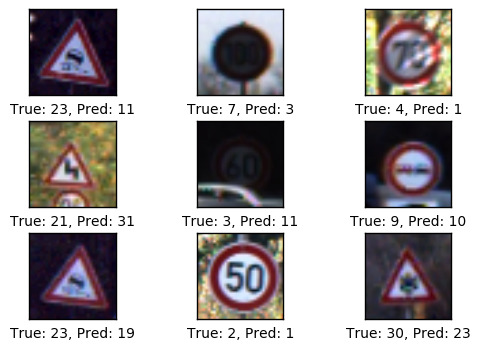

Confusion Matrix:


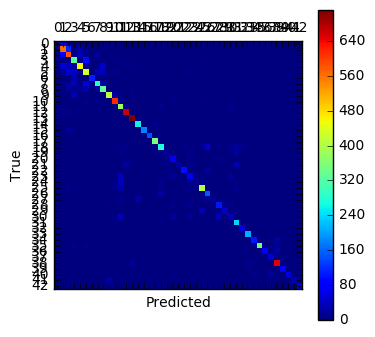

Epoch 11:
Optimization batch:      0, Training Accuracy:  79.3%
Optimization batch:    100, Training Accuracy:  80.9%
Epoch time usage: 0:01:27
Model saved in file: model.ckpt
Epoch 12:
Optimization batch:      0, Training Accuracy:  81.6%
Optimization batch:    100, Training Accuracy:  80.1%
Epoch time usage: 0:01:27
Model saved in file: model.ckpt
Epoch 13:
Optimization batch:      0, Training Accuracy:  85.9%
Optimization batch:    100, Training Accuracy:  84.8%
Epoch time usage: 0:01:27
Model saved in file: model.ckpt
Epoch 14:
Optimization batch:      0, Training Accuracy:  80.1%
Optimization batch:    100, Training Accuracy:  83.2%
Epoch time usage: 0:01:27
Model saved in file: model.ckpt
Epoch 15:
Optimization batch:      0, Training Accuracy:  83.6%
Optimization batch:    100, Training Accuracy:  86.3%
Epoch time usage: 0:01:26
Model saved in file: model.ckpt
Accuracy on Test-Set: 84.3% (10650 / 12630)
Example errors:


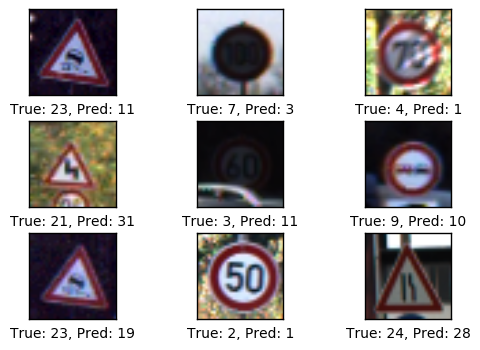

Confusion Matrix:


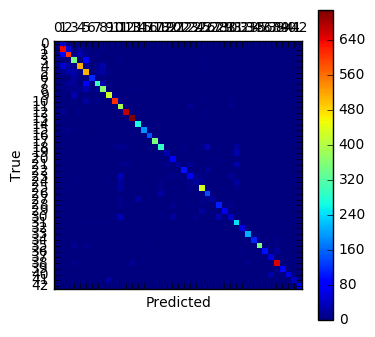

Epoch 16:
Optimization batch:      0, Training Accuracy:  84.0%
Optimization batch:    100, Training Accuracy:  89.1%
Epoch time usage: 0:01:34
Model saved in file: model.ckpt
Epoch 17:
Optimization batch:      0, Training Accuracy:  88.7%
Optimization batch:    100, Training Accuracy:  89.1%
Epoch time usage: 0:01:41
Model saved in file: model.ckpt
Epoch 18:
Optimization batch:      0, Training Accuracy:  88.7%
Optimization batch:    100, Training Accuracy:  86.3%
Epoch time usage: 0:01:34
Model saved in file: model.ckpt
Epoch 19:
Optimization batch:      0, Training Accuracy:  85.5%
Optimization batch:    100, Training Accuracy:  85.9%
Epoch time usage: 0:01:48
Model saved in file: model.ckpt
Epoch 20:
Optimization batch:      0, Training Accuracy:  89.5%
Optimization batch:    100, Training Accuracy:  89.8%
Epoch time usage: 0:02:12
Model saved in file: model.ckpt
Accuracy on Test-Set: 86.9% (10974 / 12630)
Example errors:


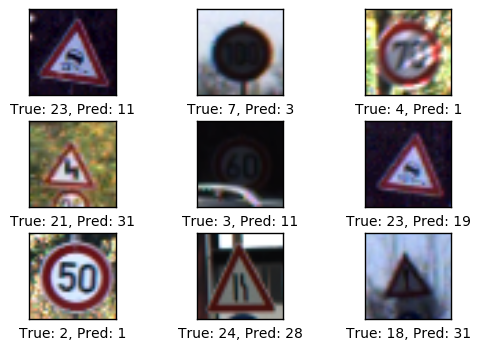

Confusion Matrix:


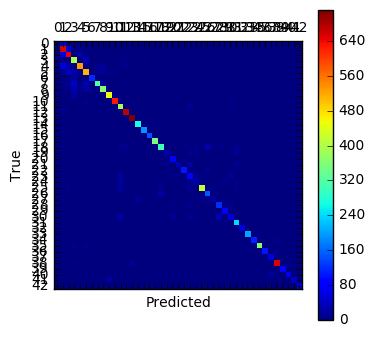

Epoch 21:
Optimization batch:      0, Training Accuracy:  86.3%
Optimization batch:    100, Training Accuracy:  88.3%
Epoch time usage: 0:01:39
Model saved in file: model.ckpt
Epoch 22:
Optimization batch:      0, Training Accuracy:  90.2%
Optimization batch:    100, Training Accuracy:  91.4%
Epoch time usage: 0:01:47
Model saved in file: model.ckpt
Epoch 23:
Optimization batch:      0, Training Accuracy:  91.4%
Optimization batch:    100, Training Accuracy:  91.4%
Epoch time usage: 0:01:50
Model saved in file: model.ckpt
Epoch 24:
Optimization batch:      0, Training Accuracy:  92.6%
Optimization batch:    100, Training Accuracy:  93.4%
Epoch time usage: 0:01:39
Model saved in file: model.ckpt
Epoch 25:
Optimization batch:      0, Training Accuracy:  89.5%
Optimization batch:    100, Training Accuracy:  93.4%
Epoch time usage: 0:02:17
Model saved in file: model.ckpt
Accuracy on Test-Set: 88.1% (11125 / 12630)
Example errors:


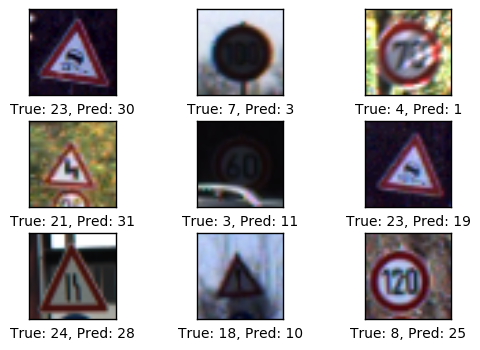

Confusion Matrix:


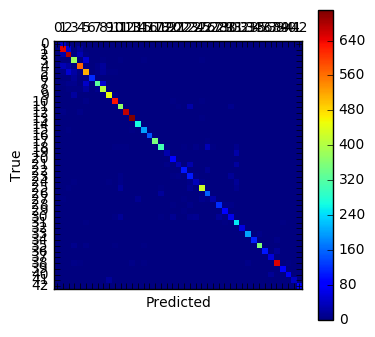

Epoch 26:
Optimization batch:      0, Training Accuracy:  91.0%
Optimization batch:    100, Training Accuracy:  91.8%
Epoch time usage: 0:01:49
Model saved in file: model.ckpt
Epoch 27:
Optimization batch:      0, Training Accuracy:  93.4%
Optimization batch:    100, Training Accuracy:  90.2%
Epoch time usage: 0:01:55
Model saved in file: model.ckpt
Epoch 28:
Optimization batch:      0, Training Accuracy:  91.0%
Optimization batch:    100, Training Accuracy:  93.0%
Epoch time usage: 0:01:49
Model saved in file: model.ckpt
Epoch 29:
Optimization batch:      0, Training Accuracy:  93.8%
Optimization batch:    100, Training Accuracy:  96.5%
Epoch time usage: 0:01:43
Model saved in file: model.ckpt
Epoch 30:
Optimization batch:      0, Training Accuracy:  93.0%
Optimization batch:    100, Training Accuracy:  92.6%
Epoch time usage: 0:01:42
Model saved in file: model.ckpt
Accuracy on Test-Set: 89.2% (11265 / 12630)
Example errors:


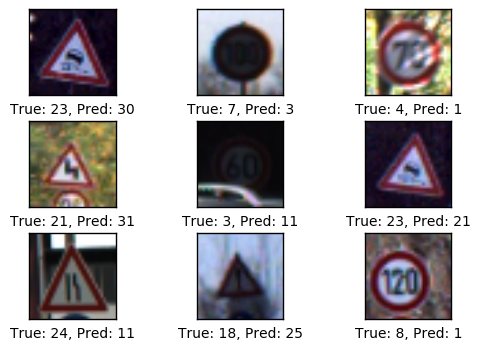

Confusion Matrix:


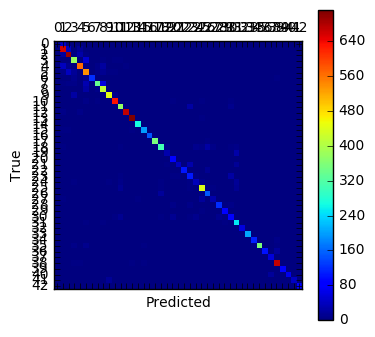

Epoch 31:
Optimization batch:      0, Training Accuracy:  93.8%
Optimization batch:    100, Training Accuracy:  94.1%
Epoch time usage: 0:01:36
Model saved in file: model.ckpt
Epoch 32:
Optimization batch:      0, Training Accuracy:  92.6%
Optimization batch:    100, Training Accuracy:  93.8%
Epoch time usage: 0:01:39
Model saved in file: model.ckpt
Epoch 33:
Optimization batch:      0, Training Accuracy:  93.0%
Optimization batch:    100, Training Accuracy:  91.0%
Epoch time usage: 0:01:48
Model saved in file: model.ckpt
Epoch 34:
Optimization batch:      0, Training Accuracy:  92.6%
Optimization batch:    100, Training Accuracy:  93.4%
Epoch time usage: 0:01:47
Model saved in file: model.ckpt
Epoch 35:
Optimization batch:      0, Training Accuracy:  94.5%
Optimization batch:    100, Training Accuracy:  93.8%
Epoch time usage: 0:01:58
Model saved in file: model.ckpt
Accuracy on Test-Set: 89.9% (11355 / 12630)
Example errors:


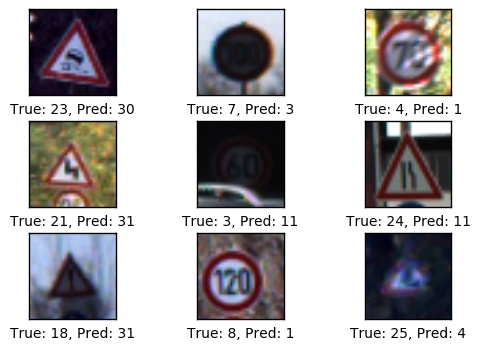

Confusion Matrix:


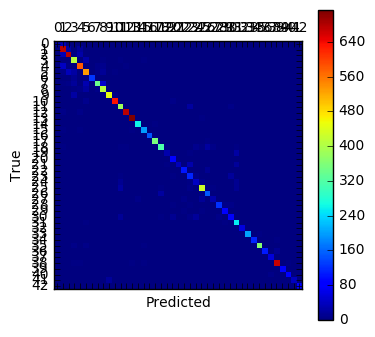

Epoch 36:
Optimization batch:      0, Training Accuracy:  95.7%
Optimization batch:    100, Training Accuracy:  90.6%
Epoch time usage: 0:01:38
Model saved in file: model.ckpt
Epoch 37:
Optimization batch:      0, Training Accuracy:  96.5%
Optimization batch:    100, Training Accuracy:  96.1%
Epoch time usage: 0:01:50
Model saved in file: model.ckpt
Epoch 38:
Optimization batch:      0, Training Accuracy:  94.5%
Optimization batch:    100, Training Accuracy:  94.9%
Epoch time usage: 0:01:46
Model saved in file: model.ckpt
Epoch 39:
Optimization batch:      0, Training Accuracy:  94.9%
Optimization batch:    100, Training Accuracy:  98.0%
Epoch time usage: 0:01:39
Model saved in file: model.ckpt
Epoch 40:
Optimization batch:      0, Training Accuracy:  96.1%
Optimization batch:    100, Training Accuracy:  96.1%
Epoch time usage: 0:01:32
Model saved in file: model.ckpt
Accuracy on Test-Set: 90.2% (11396 / 12630)
Example errors:


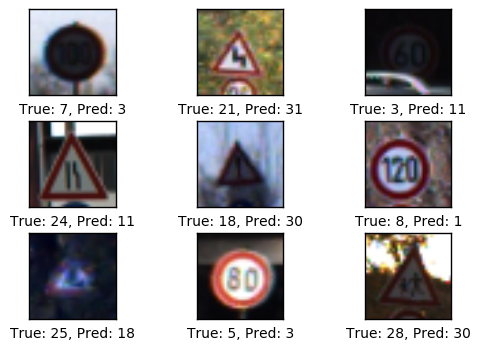

Confusion Matrix:


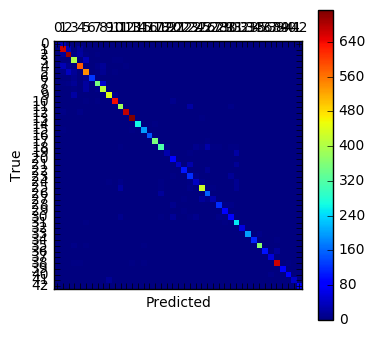

Epoch 41:
Optimization batch:      0, Training Accuracy:  96.9%
Optimization batch:    100, Training Accuracy:  96.1%
Epoch time usage: 0:01:41
Model saved in file: model.ckpt
Epoch 42:
Optimization batch:      0, Training Accuracy:  92.6%
Optimization batch:    100, Training Accuracy:  94.5%
Epoch time usage: 0:01:34
Model saved in file: model.ckpt
Epoch 43:
Optimization batch:      0, Training Accuracy:  95.3%
Optimization batch:    100, Training Accuracy:  94.9%
Epoch time usage: 0:01:30
Model saved in file: model.ckpt
Epoch 44:
Optimization batch:      0, Training Accuracy:  98.0%
Optimization batch:    100, Training Accuracy:  96.1%
Epoch time usage: 0:01:31
Model saved in file: model.ckpt
Epoch 45:
Optimization batch:      0, Training Accuracy:  94.9%
Optimization batch:    100, Training Accuracy:  94.5%
Epoch time usage: 0:01:34
Model saved in file: model.ckpt
Accuracy on Test-Set: 90.7% (11455 / 12630)
Example errors:


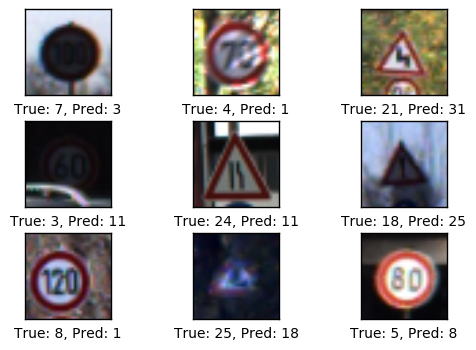

Confusion Matrix:


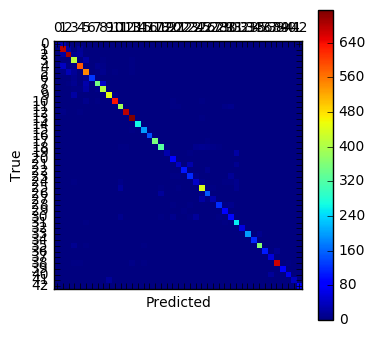

Epoch 46:
Optimization batch:      0, Training Accuracy:  96.1%
Optimization batch:    100, Training Accuracy:  98.4%
Epoch time usage: 0:01:32
Model saved in file: model.ckpt
Epoch 47:
Optimization batch:      0, Training Accuracy:  95.7%
Optimization batch:    100, Training Accuracy:  97.3%
Epoch time usage: 0:01:28
Model saved in file: model.ckpt
Epoch 48:
Optimization batch:      0, Training Accuracy:  94.9%
Optimization batch:    100, Training Accuracy:  94.5%
Epoch time usage: 0:01:48
Model saved in file: model.ckpt
Epoch 49:
Optimization batch:      0, Training Accuracy:  98.4%
Optimization batch:    100, Training Accuracy:  96.5%
Epoch time usage: 0:01:42
Model saved in file: model.ckpt


In [18]:
import os.path

# Add ops to save and restore all the variables.
saver = tf.train.Saver()
checkpoint_name = "model.ckpt"

num_epochs = 50

with tf.Session() as session:

    session.run(tf.initialize_all_variables())
    for i in range(num_epochs):        
        print ("Epoch {}:".format(i))
        optimize()
        save_path = saver.save(session, checkpoint_name)
        print("Model saved in file: %s" % save_path)
        if i%5==0:
            print_test_accuracy(True,True)
    print_test_accuracy(True,True)
        

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

I ran 50 epochs using an AdamOptimizer with learning rate 1.0e-4.
After trying a batch size of 64 initially, I increased it to 256 and got much better results. I assume that 64 classes was not enough to get most classes represented in every batch. 
I set the dropout rate after the second convolutional layer at 0.55.


### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**

I started with an example CNN that achieved good results with the MNSIT hand-written digit data, and tweaked it from there:
 https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/02_Convolutional_Neural_Network.ipynb
 
I modified the network to accept RGB values based on the intuition that the color data contained important cues for distinguishing between sign types. I noticed that the test data was performing much worse than the training data, so I added dropout after the second convolution layer to reduce overfitting. I increased the batch size to 256, to have a better chance at good representation for each of the 43 classes in each training batch. I used the tools in the sample to visualize the errors during training (e.g. drawing the confusion matrix and plotting examples of misclassified images) to better understand where the network was falling short. After seeing that darker images are causing misclassification, I added a preprocessing step to normalize the RGB values and that resulted in improved performance. 

Unfortunately, training time on my Mac was too slow to systematically evaluate more network architectures and hyperparameter values. For my next project I'll be sure to set up a GPU instance on AWS to improve iteration times and achieve better results.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

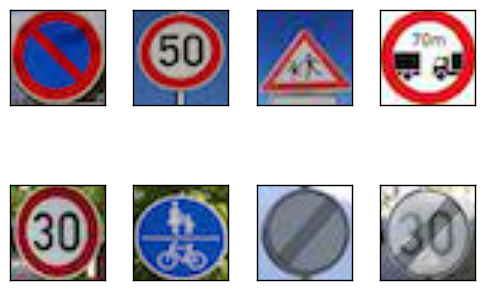

In [19]:
### Load the images and plot them here.
from scipy import misc
import os



def plot_images(images):
    # Create figure sub-plots.
    fig, axes = plt.subplots(2,4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Plot image.
            ax.imshow(images[i])

            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
def load_image(filename):
    return misc.imread(filename) 
    
def load_images(path):
    f = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        f.extend([path + '/' + filename for filename in filenames])
        break
    
    return [load_image(filename) for filename in f]

report_images = load_images('report_images')

plot_images(report_images)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**

I downloaded 8 images of German traffic signs from the internet and scaled/cropped them to 32x32. Some of them are completely unrelated to any signs in the project data, and others are related but slightly different (e.g. I downloaded an image for "end of speed limit 30kph", but the data contains a similar-looking sign for "end of speed limit 80kph").

In [20]:
import tensorflow as tf

report_labels = np.zeros(shape=len(report_images), dtype=np.int)


### Run the predictions here.
with tf.Session() as session:

    # Restore variables from disk.
    saver = tf.train.Saver()
    checkpoint_name = "model.ckpt"
    saver.restore(session, checkpoint_name)
    
    # Create a feed-dict with these images and labels.
    feed_dict = {x: to_flattened_rgb(report_images),
                 y_true: mnist.dense_to_one_hot(report_labels, n_classes),
                 keep_prob: 1.}

    # Calculate the predicted class using TensorFlow.
    (pred, top_k_out) = session.run((y_pred, top_k), feed_dict=feed_dict)
    
    print(np.argmax(pred, axis=1))

[40  7 28 35  1 35 32  6]


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**

It did reasonably OK. It correclty guessed 3 of 4 signs that existed in the data set (it misclassified the "50kph" sign, though with low certainty).

It was oddly certain about its incorrect predictions for two signs that were not in the data set.

And it somewhat endearingly classified the "end 30kph" sign to its nearest relative in the data set ("end 80kph").

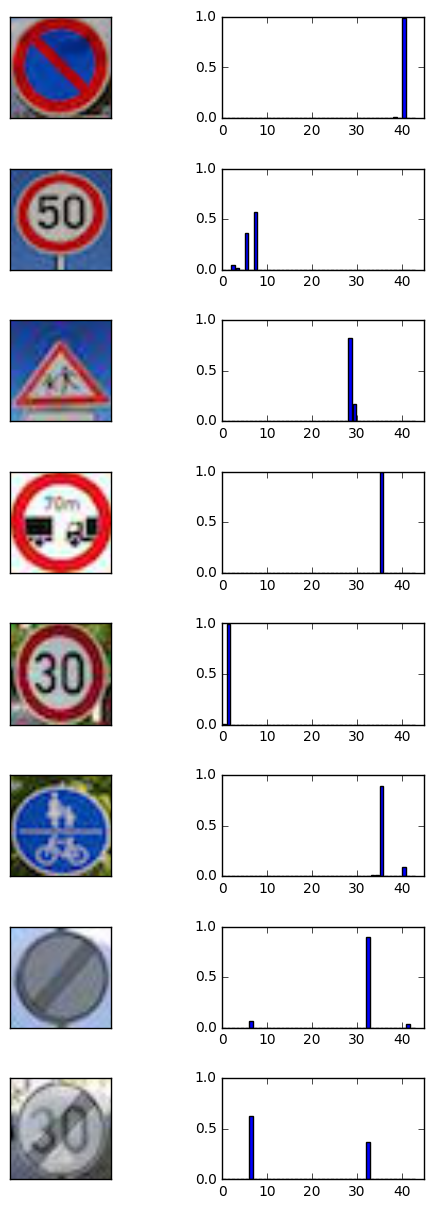

In [21]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
fig, axes = plt.subplots(8,2)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
fig.set_figheight(15)

for i, ax in enumerate(axes.flat):
    if i%2:
        ax.bar(np.arange(n_classes), pred[int(i/2)])
        ax.set_xticks((0,10,20,30,40), minor=False)
        ax.set_yticks((0,0.5,1.), minor=False)
    else:
        ax.imshow(report_images[int(i/2)])
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**

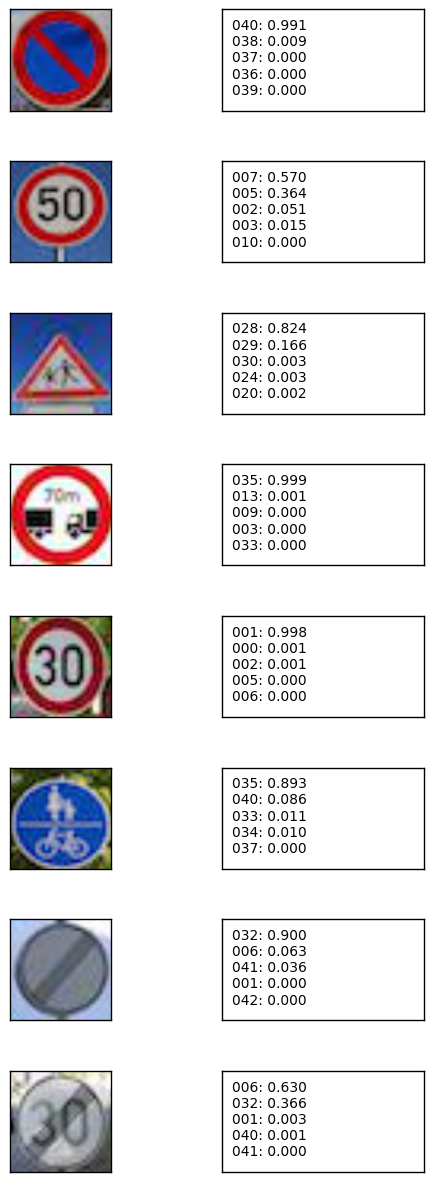

In [22]:
fig, axes = plt.subplots(8,2)
fig.subplots_adjust(hspace=0.5, wspace=0.3)
fig.set_figheight(15)

for i, ax in enumerate(axes.flat):
    index = int(i/2)
    if i%2:
        certainty_str = ""
        for index,certainty in zip(top_k_out.indices[index],top_k_out.values[index]):
            certainty_str += "{:03}: {:.3f}\n".format(index, certainty)
        ax.text(0.05,0, certainty_str, wrap=True)
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.imshow(report_images[int(i/2)])
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
plt.show()

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.